# MLFLOW setup in Jupyter Notebook

This notebook contains a small Data Science Project where MLFlow is used to log all Feature Engineering and Modeling Parameters as well as Metrics.



## Loading Data

In [25]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import warnings
import mlflow
import matplotlib.pyplot as plt
import rasterio
import geopandas as geopd

from rasterio.plot import show
from modeling.config import EXPERIMENT_NAME

import pyreadr



In [2]:
result = pyreadr.read_r('../data/r_files/track_all.RDS') 
result_resamp = pyreadr.read_r('../data/r_files/track_resamp.RDS') 
#result_covar = pyreadr.read_r('../data/r_files/covariates.RDS') 

In [3]:
foxy_df = result[None]
foxy_df_resamp = result_resamp[None]

In [4]:
foxy_df_resamp

,id,sex,x_,y_,t_,burst_
0,2018-FSBD608-001,F,548522.717454,7.353167e+06,2018-07-10 01:56:30,1.0
1,2018-FSBD608-001,F,548525.680513,7.353168e+06,2018-07-10 06:56:32,2.0
2,2018-FSBD608-001,F,548539.963810,7.353164e+06,2018-07-10 11:56:32,3.0
3,2018-FSBD608-001,F,548195.507163,7.352493e+06,2018-07-10 22:31:11,4.0
4,2018-FSBD608-001,F,548558.891944,7.352589e+06,2018-07-11 13:31:01,5.0
...,...,...,...,...,...,...
15078,2019-FSBD641_y-gr/r-b,M,543632.466003,7.379183e+06,2019-12-14 08:10:19,49.0
15079,2019-FSBD641_y-gr/r-b,M,544607.109028,7.378558e+06,2019-12-14 12:10:15,50.0
15080,2019-FSBD641_y-gr/r-b,M,544147.656802,7.379631e+06,2019-12-14 16:10:13,51.0
15081,2019-FSBD641_y-gr/r-b,M,539474.780875,7.379241e+06,2019-12-15 00:10:14,52.0


In [23]:
elev = rasterio.open("../data/Rasters_for_R/DEM_30.tif")
aspect = rasterio.open("../data/Rasters_for_R/aspect_30.tif")
NDVI_NDMI = rasterio.open("../data/Rasters_for_R/NDVI_arj_vind.tif")
slope = rasterio.open("../data/Rasters_for_R/slope_arj_vind.tif")
veg = rasterio.open("../data/Rasters_for_R/veg_nofor_morecats.tif")
soil = rasterio.open("../data/Rasters_for_R/soil_av_clip.tif")
# rasterio.plot.show(NDVI_NDMI)
NDVI = rasterio.band(NDVI_NDMI, 3)
NDMI = rasterio.band(NDVI_NDMI, 2)


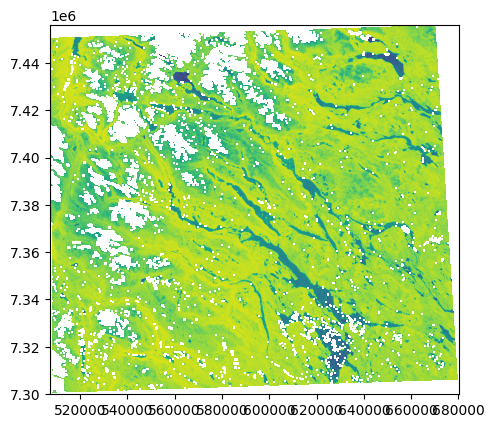

<AxesSubplot:>

In [21]:
rasterio.plot.show(NDMI)


In [ ]:

rasterio.plot.show(aspect)


<AxesSubplot:>

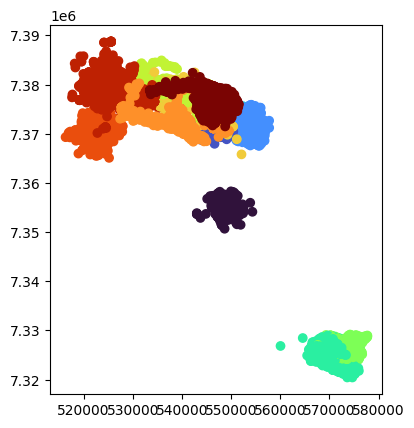

In [33]:
gdf = geopd.GeoDataFrame(
    foxy_df, geometry=geopd.points_from_xy(foxy_df.x_, foxy_df.y_))
gdf.head()
gdf.plot("id", cmap = "turbo")


In [6]:
Y = coffee_quality["quality_score"]

NameError: name 'coffee_quality' is not defined

## Data cleaning and feature engineering

In [ ]:
coffee_features.info()

In [ ]:
#for this exercise we will only deal with numeric variables

X = coffee_features.select_dtypes(['number'])

## Splitting data for testing 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [ ]:
#dropping Quakers column and unnamed
#changing one of the altitude to log and droping the original
X_train["altitude_mean_log"] = np.log(X_train["altitude_mean_meters"])
X_train.drop(['altitude_mean_meters'], axis=1, inplace=True)
X_train.drop(['Quakers'], axis=1, inplace=True)
X_train.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
X_train.info()

In [ ]:
altitude_low_meters_mean = X_train["altitude_low_meters"].mean()
altitude_high_meters_mean = X_train["altitude_high_meters"].mean()
altitude_mean_log_mean = X_train["altitude_mean_log"].mean()

In [ ]:
# fillna with mean.. 
X_train["altitude_low_meters"] = X_train["altitude_low_meters"].fillna(altitude_low_meters_mean)
X_train["altitude_high_meters"] = X_train["altitude_high_meters"].fillna(altitude_high_meters_mean)
X_train["altitude_mean_log"] = X_train["altitude_mean_log"].fillna(altitude_mean_log_mean)

In [ ]:
print(f"altitude low meters mean is {altitude_low_meters_mean}")
print(f"altitude_high_meters_mean is {altitude_high_meters_mean}")
print(f"altitude_mean_log_mean is {altitude_mean_log_mean}")

## Trainining the model and tracking with MLFlow

In [ ]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()

In [ ]:
print("Active run_id: {}".format(run.info.run_id))

In [ ]:
#training the model
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
#model metric on training data
from sklearn.metrics import mean_squared_error
y_train_pred = reg.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print(mse_train)

In [ ]:
# feature engineering of test data
#dropping Quakers column and unnamed
#changing one of the altitude to log and droping the original
X_test["altitude_mean_log"] = np.log(X_test["altitude_mean_meters"])
X_test.drop(['altitude_mean_meters'], axis=1, inplace=True)
X_test.drop(['Quakers'], axis=1, inplace=True)
X_test.drop(['Unnamed: 0'], axis=1, inplace=True)
# fillna with mean.. 
X_test["altitude_low_meters"] = X_test["altitude_low_meters"].fillna(altitude_low_meters_mean)
X_test["altitude_high_meters"] = X_test["altitude_high_meters"].fillna(altitude_high_meters_mean)
X_test["altitude_mean_log"] = X_test["altitude_mean_log"].fillna(altitude_mean_log_mean)

In [ ]:
#model metric on test data
y_test_pred = reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(mse_test)

In [ ]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "altitude_low_meters_mean": altitude_low_meters_mean,
      "altitude_high_meters_mean": altitude_high_meters_mean,
      "altitude_mean_log_mean": altitude_mean_log_mean,
      "fit_intercept": True,
  }

In [ ]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("train-" + "MSE", mse_train)
mlflow.log_metric("test-" + "MSE", mse_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

In [ ]:
mlflow.get_run(run_id=run.info.run_id)

## Checking the experiments

while the next cell is running you will not be able to run other cells in the notebook

In [ ]:
!mlflow ui